In [1]:
# Imports
import torch
from torch import nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm
print("all modules imported")

all modules imported


In [3]:
# define simple neural network class
class simple_NN(nn.Module):
    def __init__(self):
        super(simple_NN, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        out = self.linear_tanh_stack(x)
        return out

In [2]:
# create dataset

x_train = torch.tensor([[1.1437e-04],
        [1.4676e-01],
        [3.0233e-01],
        [4.1702e-01],
        [7.2032e-01]], dtype=torch.float32)
y_train = torch.tensor([[1.0000],
        [1.0141],
        [1.0456],
        [1.0753],
        [1.1565]], dtype=torch.float32)

In [4]:
# Initialize the model
model = simple_NN()

# define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Train
for ep in range(1000):

    # Compute prediction error
    pred = model(x_train)
    loss = loss_fn(pred, y_train)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 200 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 1.523582
epoch: 200, loss: 0.000314
epoch: 400, loss: 0.000228
epoch: 600, loss: 0.000147
epoch: 800, loss: 0.000054


In [5]:
# Define the domain where to evaluate the function
domain = [0.0, 1.5]
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = model(x_eval)

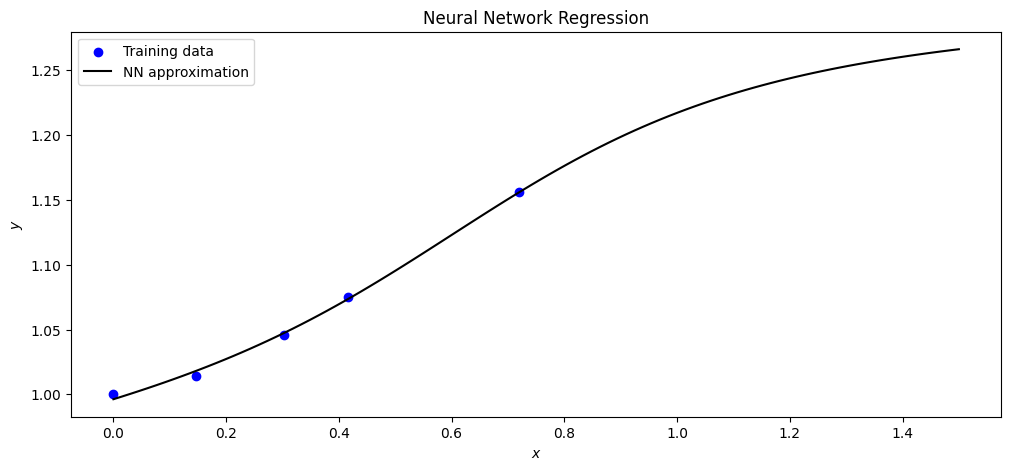

In [6]:
# plotting
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Training data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN approximation", color="black")
ax.set(title="Neural Network Regression", xlabel="$x$", ylabel="$y$")
ax.legend();

Starting with PINN

The population growth equation
df(t)/dt = Rt(1-t) is the governing equation
with boundary condition f(t=0) = 1

In [11]:
R = 1.0
ft0 = 1.0
def df(f: simple_NN, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    df_value = f(x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x), # computing gradient of a scalar output w.r.t. input
            create_graph=True,
            retain_graph=True
        )[0]
    return df_value


The neural net needs to satisfy:
dNN(t)/dt - Rt(t-1) = 0 from governing equation
define the loss function as L_PDE = (1/N)sum_1_to_N(dNN/dt-t(1-t))^2 (the MSE of the sum of the mean squared error between the gradient nad the actual expected gradient)

In [8]:
# generate 10 evenly distributed collocation points for training
t = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True).reshape(-1, 1)

define also a loss function L_BC = (NN(t_0)-1)^2 thanks to the boundary condition

The total loss funcition = L_PDE + L_BC + L_data

In [18]:
def compute_loss(model: simple_NN,
                 t: torch.Tensor = None,
                 x: torch.Tensor = None,
                 y: torch.Tensor = None) -> torch.float:
    pde = df(model, t) - R * t * (1 - t)
    pde_loss = pde.pow(2).mean()

    # boundary at t = 0, make sure shape is (1,1) and dtype/device match t
    t0 = torch.tensor([[0.0]], dtype=t.dtype, device=t.device, requires_grad=True)
    bc_pred = model(t0)
    bc_target = torch.tensor([[ft0]], dtype=t.dtype, device=t.device)
    bc_loss = (bc_pred - bc_target).pow(2).mean()

    mse_loss = torch.nn.MSELoss()(model(x), y)

    tot_loss = pde_loss + bc_loss + mse_loss
    return tot_loss

In [19]:
model = simple_NN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(2000):
    loss = compute_loss(model, t, x_train, y_train)

    #backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"epoch: {epoch}, loss: {loss.item():>7f}")

epoch: 0, loss: 1.842264
epoch: 200, loss: 0.000567
epoch: 400, loss: 0.000165
epoch: 600, loss: 0.000109
epoch: 800, loss: 0.000092
epoch: 1000, loss: 0.000085
epoch: 1200, loss: 0.000083
epoch: 1400, loss: 0.000083
epoch: 1600, loss: 0.000342
epoch: 1800, loss: 0.000086


In [20]:
# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=x_eval.squeeze().detach().numpy()
)

f_colloc = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=t.squeeze().detach().numpy()
).y.T

In [21]:
f_PINN_eval = model(x_eval)

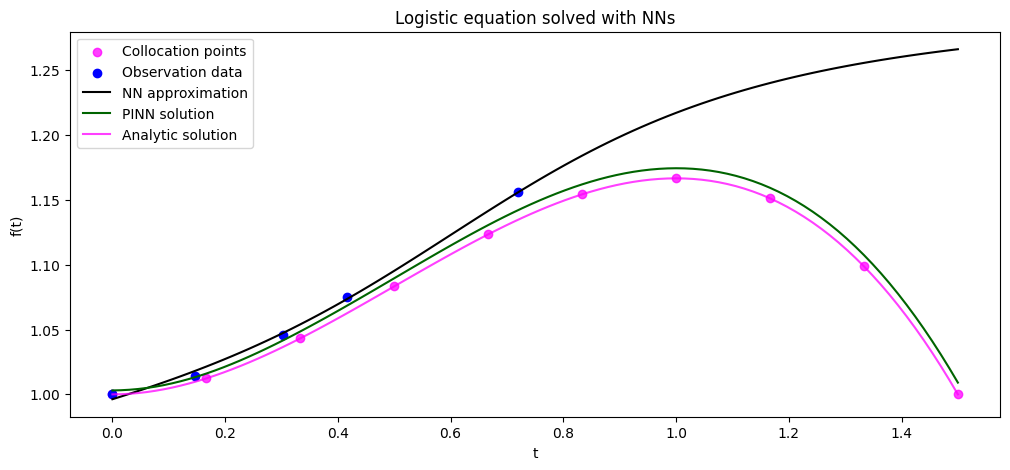

In [22]:
# plotting
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(t.detach().numpy(), f_colloc, label="Collocation points", color="magenta", alpha=0.75)
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Observation data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN approximation", color="black")
ax.plot(x_eval.detach().numpy(), f_PINN_eval.detach().numpy(), label="PINN solution", color="darkgreen")
ax.plot(x_eval.detach().numpy(), numeric_solution.y.T,
        label="Analytic solution", color="magenta", alpha=0.75)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend();

PINN for a 1d wave